# **Разбиение отрезка интегрирования на основе поиска локальных экстремумов функции**

При разбиении отрезка интегрирования на $n$ частей получим $n_1 = n + 1$ точку, по которым вычисляется интегральная сумма. При размещении этих $n_1$ точек в локальных экстремумах интегрируемой функции $f(x)$ возможно возникновение 3 различных ситуаций:
1. число экстремумов функции $f(x)$ равно числу точек интегрирования: $n_{extr} = n_1$
1. число экстремумов функции $f(x)$ больше числа точек интегрирования: $n_{extr} > n_1$
1. число экстремумов функции $f(x)$ меньше числа точек интегрирования: $n_{extr} < n_1$


1) Первая ситуация является тривиальной в том смысле, что точки интегрирования просто располагаются в точках локальных экстремумов функции $f(x)$, и после этого не остаётся ни неразмещённых точек интегрирования ни незанятых точек экстремума.

2) В случае когда $n_{extr} > n_1$, предлагается отсортировать массив модулей значений функции в точках экстремума по убыванию $$|f(x_{i_1})| \geq |f(x_{i_2})| \geq ... \geq |f(x_{i_{n_{extr} - 1}})| \geq |f(x_{i_{n_{extr}}})|$$ и выбрать в качестве точек интегрирования первые $n_{maj\_extr} = n_1 < n_{extr}$, из этих точек: $(x_{i_1}, x_{i_2}, ..., x_{i_{n_{maj\_extr}}})$.

3) Для случая $n_{extr} < n_1$ было рассмотрено два варианта алгоритма. Для обоих вариантов сначала первые $n_{extr}$ из $n$ точек интегрирования размещаются в точках локальных экстремумов функции $f(x)$.

После этого в первом варианте (I): оставшиеся $n_1 - n_{extr}$ точек интегрирования размещаются равномерно на отрезке $[0,1]$, а во втором (II): оставшиеся точки размещаются равномерно на каждом из отрезков, концами которых являются точки множества ${X_{extr} \cup \{0, 1\} }$, где $X_{extr}$ - множество точек экстремума функции $f(x)$. При этом количество точек интегрирования, попавших в каждый такой отрезок, пропорционально его длине.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
x_extr = find_x_extr(f, eps_y) - функция, выполняющая поиск локальных экстремумов на отрезке [0, 1]

f - функция, локальные экстремумы которой необходимо найти
eps_y - погрешность аппроксимации функции кусочно-линейной интерполяцией
x_extr - массив точек локальных экстремумов функции f(x)
'''
def find_x_extr(f, eps_x=1e-6, eps_y=1e-6):
  # начальное кол-во точек для построения кусочно-линейной аппроксимации
  N = 32
  x = np.linspace(0, 1, N)
  f_diff = np.diff(f(x))

  # сетка сгущается каждую итерацию в 2 раза, пока не будет выполнено условие:
  while (np.max(np.abs(f_diff)) >= eps_y):
    N *= 2
    x = np.linspace(0, 1, N)
    f_diff = np.diff(f(x))

  # точки экстремума в массиве x определяются как точки x[i], в которых разность соседних значений дискретного представления f(x)
  # меняет знак: sign(diff_f[i - 1]) == -sign(diff_f[i]), либо если (sign(diff_f[i]) == 0 и sign(diff_f[i - 1]) == -sign(diff_f[i + 1]))
  sign_diff_f = np.sign(f_diff)
  extr_ind = np.array([i for i in range(1, len(sign_diff_f) - 1) \
  if (sign_diff_f[i - 1] == -sign_diff_f[i]) ^ (sign_diff_f[i - 1] == -sign_diff_f[i + 1] and sign_diff_f[i] == 0)])

  x_extr = x[extr_ind]
  x_extr.sort()

  return x_extr

'''
В случае когда n_extr < n1, первые n_extr точек интегрирования размещаются в локальных экстремумах функции f(x),
а остальные n1 - n_extr размещаются равномерно либо на всём отрезке [0, 1], либо между уже размещёнными точками.

Если в окрестности некоторой точки интегрирования изменение функции f(x) пренебрежимо мало (настолько, что её можно считать постоянной в этой области),
то размещение в этой окрестности других точек интегрирования приведёт к незначительному увеличению точности апроксимации интегральной суммой
истинного значения интеграла от f(x).

Возможны ситуации, когда некоторые из размещённых точек, могут оказаться расположены слишком близко друг к другу.
Например, когда расположение n_extr точек локальных экстремумов совпадает с расположением оставшихся n1 - n_extr точек
интегрирования при их равномерном размещении на отрезке [0, 1] (или очень близко к нему) ).

Поэтому для экономии вычислительных ресурсов точки интегрирования и большей точности вычислений, не размещённые в локальных экстремумах, но расположенные
очень близко к ним переразмещаются (равномерно между уже размещёнными точками интегрирования) с помощью функции match_exten:

res = match_exten(int_x, f, eps_x) - функция переразмещения точек интегрирования

int_x - начальное положение точек интегрирования
f - интегрируемая функция
eps_x - при расстоянии между точками интегрирования, меньшем чем eps_x, они "раздвигаются" (переразмещаются)
res - массив координат размещённых точек интегрирования
'''
def match_exten(int_x, f, eps_x=1e-6):
  i = 0
  N = 1

  # подсчитывается количество идущих подряд точек интегрирования, расстояние между которыми меньше, чем eps_x
  while i < (len(int_x) - 1):
    if np.abs(int_x[i] - int_x[i + 1]) < eps_x and (i != (len(int_x) - 2)):
      N += 1
    elif (N > 1):

      # если точки интегрирования, расстояние между которыми меньше чем eps_x, расположены между точкой 0 и точкой первого экстремума x_extr[0],
      # то они переразмещаются равномерно на отрезке [0, x_extr[0]]
      if i == (N - 1):
        int_x[i - N + 1:i + 2] = np.linspace(int_x[i - N + 1], int_x[i + 1], N + 1)

      # если точки интегрирования, расстояние между которыми меньше чем eps_x, расположены между точкой последнего экстремума x_extr[-1] и точкой 1
      # то они переразмещаются равномерно на отрезке [x_extr[-1], 1]
      elif np.abs(int_x[i] - int_x[i + 1]) < eps_x:
        int_x[i - N:i + 2] = np.linspace(int_x[i - N], int_x[i + 1], N + 2)

      # если точки интегрирования расположены в окрестности eps_x, локального экстремума x_extr[i]
      # то они переразмещаются равномерно на отрезках [x_extr[i - 1], x_extr[i]] и [x_extr[i], x_extr[i + 1]]
      # кол-во точек, попавших в каждый их этих отрезков, пропорционально модулям разности значений
      # функции f(x) на концах этих отрезков
      else:
        left_diff = np.abs(f(int_x[i - N + 1]) - f(int_x[i - N]))
        right_diff = np.abs(f(int_x[i + 1]) - f(int_x[i]))
        diff_rat = int(max(left_diff, right_diff) // min(left_diff, right_diff))
        N_max = (N - 1) * diff_rat // (1 + diff_rat)
        N_min = N - 1 - N_max
        N_right = N_min if left_diff >= right_diff else N_max

        # размещение точек на отрезке [x_extr[i - 1], x_extr[i]]
        int_x[i - N:i - N_right + 1] = np.linspace(int_x[i - N], int_x[i - N_right], N - N_right + 1)
        # размещение точек на отрезке [x_extr[i], x_extr[i + 1]]
        int_x[i - N_right:i + 2] = np.linspace(int_x[i - N_right], int_x[i + 1], N_right + 2)
      N = 1
    i += 1
  return int_x


'''
res = uniform_for_each_segm(x_extr, n) - функция, размещающая точки интегрирования равномерно на отрезках между точками
локальных экстремумов функции f(x)

x_extr - массив точек локальных экстремумов функции f(x)
n - количество отрезков, на которые необходимо разбить отрезок [0, 1]
res - массив координат размещённых точек интегрирования
'''
def uniform_for_each_segm(x_extr, n):
  # кол-во точек, которые необходимо разместить и которые не попали в точки локальных экстремумов функции f(x)
  n_non_extr = n + 1 - len(x_extr)
  segments = np.array([(x1, x2) for x1, x2 in zip(x_extr, x_extr[1:])])
  len_segm = np.array([x2 - x1 for x1, x2 in zip(x_extr, x_extr[1:])])
  segm_ind = np.argsort(len_segm)
  segm_points = np.zeros(len_segm.shape, dtype=np.int64)
  all_points = set()
  L = n_non_extr
  # точки интегрирования размещаются равномерно на каждом отрезке, концами которого уже размещённые точки (в локальных экстремумах, или в точках 0, или 1)
  for i in segm_ind[-1::-1]:
    if L > 0:
      segm_points[i] = min(np.ceil(len_segm[i] * n_non_extr), L)
      L -= segm_points[i]
    points = np.linspace(segments[i,0], segments[i,1], segm_points[i] + 2)
    all_points = all_points.union(points)

  all_points = np.array(list(all_points))
  all_points.sort()

  return all_points

'''
res = uniform(n) - функция, разбивающая отрезок [0, 1] на n равных частей

n - кол-во отрезков разбиения
res - массив координат размещённых точек интегрирования
'''
def uniform(n):
  return np.linspace(0, 1, n + 1)

'''
Размещение точек интегрирования непрерывной на отрезке [0, 1] функции f(x) в точках её локальных экстремумов

res = loc_extr_int(f, n, uniform_for_each = 1)

f - интегрируемая функция f(x)
n - кол-во отрезков разбиения
uniform_for_each - флаг, отвечающий за размещение точек интегрирования, не попавших в лок. экстремумы функции f(x): (1 - равномерно на каждом отрезке
между уже размещёнными точками, 0 - равномерно на всём отрезке интегрирования [0, 1])
res - массив координат размещённых точек интегрирования
'''
def loc_extr_int(f, n, uniform_for_each = 1):
  # поиск точек экстремума
  x_extr = find_x_extr(f)

  # размещение точек интегрирования в локальных экстремумах функции f(x)
  ind_extr = np.argsort(np.abs(f(x_extr)))[-1::-1]
  sorted_x_extr = x_extr[ind_extr]
  maj_x_extr = sorted_x_extr[:min(len(sorted_x_extr), n - 1)]
  if uniform_for_each:
    # размещение оставшихся точек равномерно на каждом отрезке, концами которого являются
    # точки локальных экстремумов f(x) либо точки 0 или 1
    maj_x_extr = np.concatenate((maj_x_extr, np.array([0., 1.])))
    maj_x_extr.sort()
    return uniform_for_each_segm(maj_x_extr, n)
  else:
    # размещение оставшихся точек равномерно по всему отрезку интегрирования [0, 1]
    all_points = uniform(n - len(maj_x_extr))
    all_points = np.concatenate((maj_x_extr, all_points))
    all_points.sort()
    all_points = match_exten(all_points, f)
    return all_points



In [3]:
# Для тестирования алгоритмов рассмотрим две функции, непрерывные на отрезке [0, 1]
# При аналитическом решении значение интеграла от этих функций по отрезку [0, 1] равно I_true = 1
f1 = lambda x: 0.5 * x - x ** 3 + 1 - 0.3 * np.cos(x*np.pi * 7)
f2 = lambda x: (2/3) * x - x ** 2 + 1 + 0.05 * np.cos(x*np.pi * 4) + 0.1 * np.cos(x*np.pi * 5)

funcs = [f1, f2]

x = np.linspace(0, 1, 10000)
n = 20

int_points_f1_u = uniform(n)
int_points_f2_u = uniform(n)

int_points_f1_0 = loc_extr_int(f1, n, 0)
int_points_f2_0 = loc_extr_int(f2, n, 0)

int_points_f1_1 = loc_extr_int(f1, n, 1)
int_points_f2_1 = loc_extr_int(f2, n, 1)

all_points = [int_points_f1_u, int_points_f2_u, int_points_f1_0, int_points_f2_0, int_points_f1_1, int_points_f2_1]

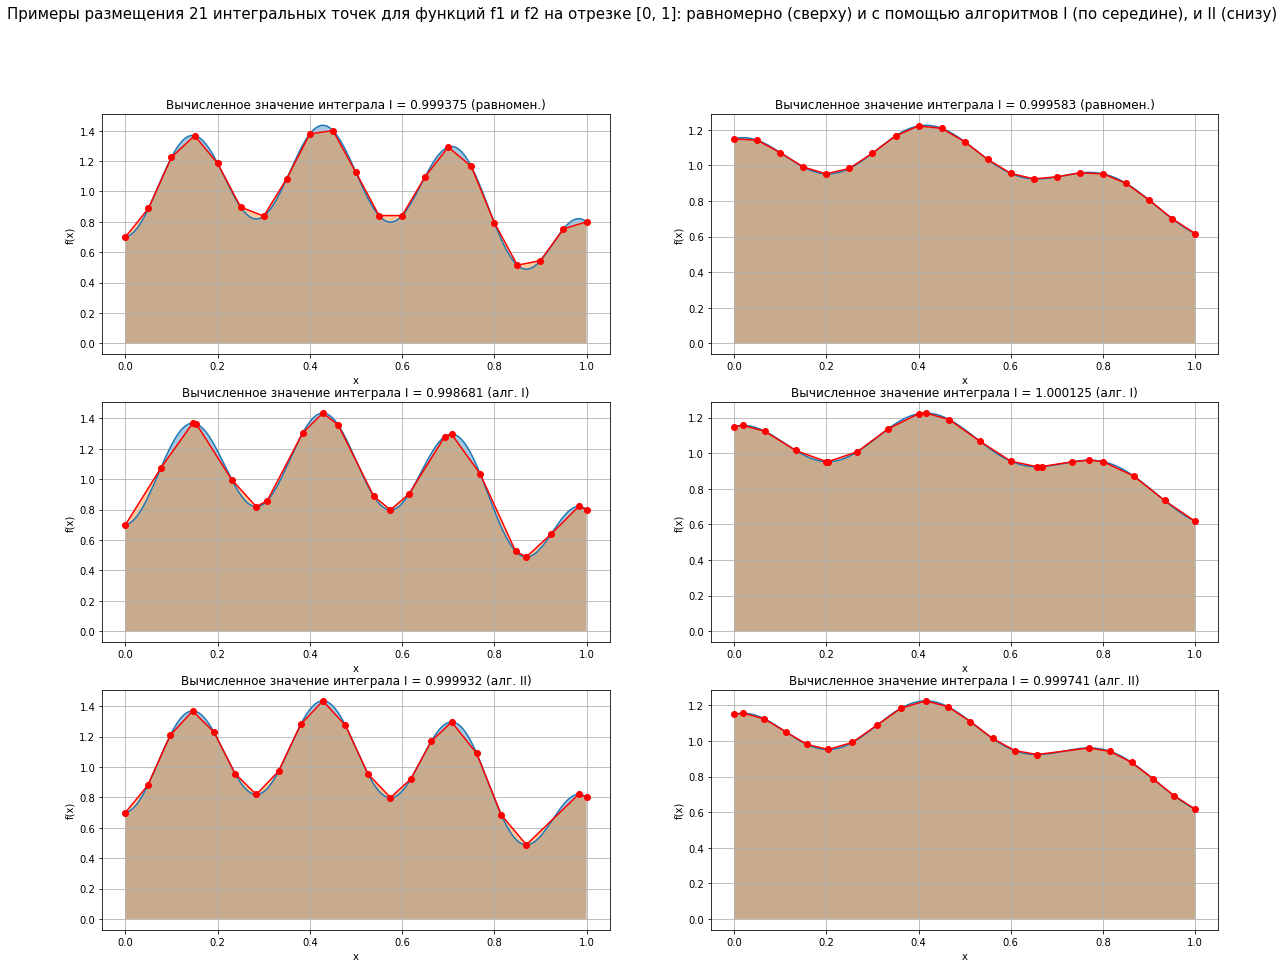

In [4]:
string = ['(равномен.)', '(алг. I)', '(алг. II)']
plt.figure(figsize = (20,15))
plt.suptitle(f'Примеры размещения {n + 1} интегральных точек для функций f1 и f2 на отрезке [0, 1]: равномерно (сверху) и c помощью алгоритмов I (по середине), и II (снизу)', fontsize=15);

for i in range(6):
  f = funcs[i % 2]
  plt.subplot(3,2,i + 1)
  plt.plot(x,f(x))
  plt.fill_between(x, f(x), alpha = 0.4)
  plt.plot(all_points[i],f(all_points[i]), '-r.', markersize=12)
  plt.fill_between(all_points[i], f(all_points[i]), alpha = 0.4)
  plt.grid()
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.title(f'Вычисленное значение интеграла I = {np.round(np.trapz(f(all_points[i]),all_points[i]), 6)} {string[i // 2]}')

In [5]:
'''
I_error = test_func(f, n_values, int_alg, I_true) - функция для тестирования алгоритмов интегрирования

f - интегрируемая функция
n_values - массив чисел, соотвествующих кол-вам отрезков разбиения исходного отрезка [0, 1]
int_alg - алгоритм размещения точек интегрирования
I_true - истинное значение определённого интеграла от f(x) по отрезку [0, 1]

I_error - список значений модуля разности между вычисленной интегральной суммой и истинным значением интеграла для каждого значения из n_values
'''
def test_func(f, n_values, int_alg, I_true):
  I_error = []
  for n in n_values:
    int_x = int_alg(f, n)
    I_error.append(np.abs(I_true - np.trapz(f(int_x),int_x)))
  return I_error

In [6]:
f1 = lambda x: 0.5 * x - x ** 3 + 1 - 0.3 * np.cos(x*np.pi * 7)
f2 = lambda x: (2/3) * x - x ** 2 + 1 + 0.05 * np.cos(x*np.pi * 4) + 0.1 * np.cos(x*np.pi * 5)

int_algs = [lambda _, n: uniform(n), lambda f, n: loc_extr_int(f, n, uniform_for_each = 0), lambda f, n: loc_extr_int(f, n, uniform_for_each = 1)]

n_values = np.array([5, 7, 10, 20, 30, 50, 100, 250, 500, 1000])

I_true = 1.

# Тестирование алгоритмов на функции f1
I_algs1 = []
for int_alg in int_algs:
  I_algs1.append(test_func(f1, n_values,int_alg, I_true))

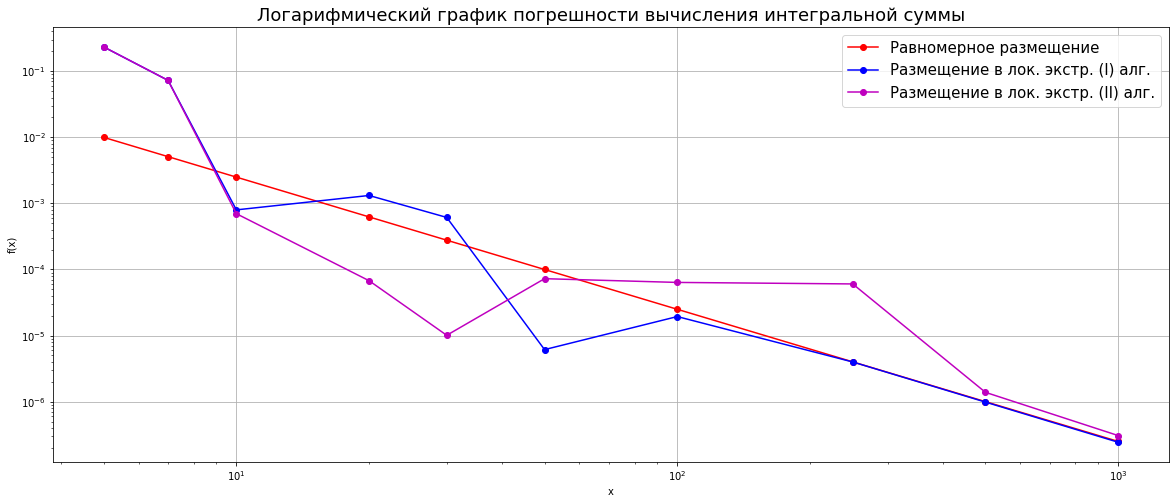

In [7]:
plt.figure(figsize = (20,8))

plt.loglog(n_values,I_algs1[0], '-r.', markersize=12)
plt.loglog(n_values,I_algs1[1], '-b.', markersize=12)
plt.loglog(n_values,I_algs1[2], '-m.', markersize=12)
plt.legend(['Равномерное размещение', 'Размещение в лок. экстр. (I) алг.', 'Размещение в лок. экстр. (II) алг.'], prop={'size': 15})
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Логарифмический график погрешности вычисления интегральной суммы', fontdict={'fontsize': 18});

In [8]:
# Тестирование алгоритмов на функции f2
I_algs2 = []
for int_alg in int_algs:
  I_algs2.append(test_func(f2, n_values,int_alg, I_true))

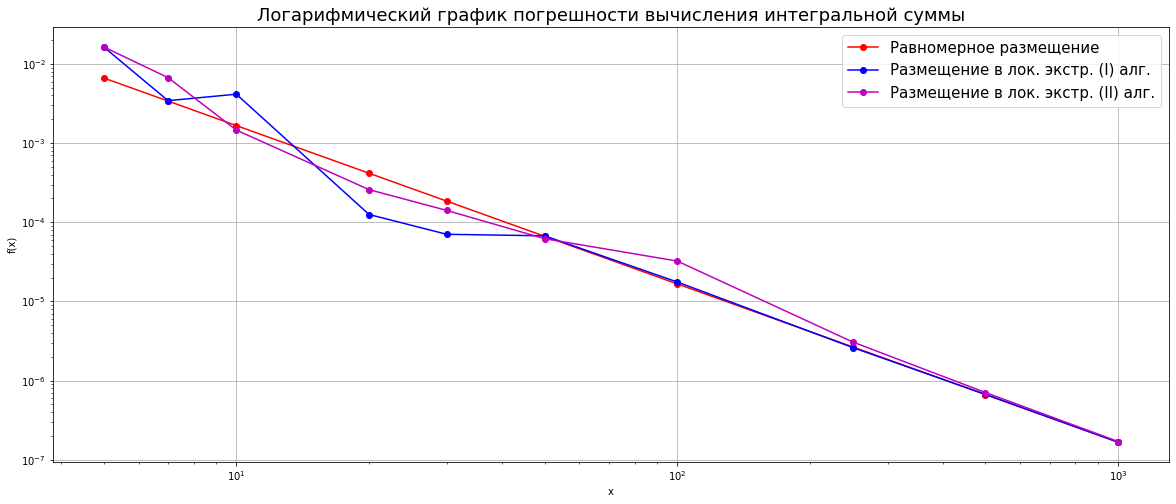

In [9]:
plt.figure(figsize = (20,8))

plt.loglog(n_values,I_algs2[0], '-r.', markersize=12)
plt.loglog(n_values,I_algs2[1], '-b.', markersize=12)
plt.loglog(n_values,I_algs2[2], '-m.', markersize=12)
plt.legend(['Равномерное размещение', 'Размещение в лок. экстр. (I) алг.', 'Размещение в лок. экстр. (II) алг.'], prop={'size': 15})
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Логарифмический график погрешности вычисления интегральной суммы', fontdict={'fontsize': 18});

## **Выводы:**

1. По результатам экспериментов можно видеть, что рассмотренные адаптивные алгоритмы интегрирования I и II демонстрируют наилучшие по точности результаты при $$ n_{extr} < n_{int} < 100, $$ где $n_{int}$ - количество внутренних точек интегрирования (имеются в виду точки интегрирования, принадлежащие интервалу $(1, 0)$), $n_{extr}$ - кол-во лок. экстремумов на отрезке $[0, 1]$ интегрируемой функции $f(x)$.

1. При меньшем кол-ве точек интегрирования их равномерное расположение по отрезку $[0, 1]$ (без учёта расположения локальных экстремумов $f(x)$) даёт большую точность вычислений, в смысле минимума модуля разности истинного значения интеграла и значения найденной интегральной суммы. При  $n_{int} \geq 100$, учёт расположения локальных экстремумов не обеспечивает существенного прироста точности, по сравнению с равномерным расположением точек.

1. Наибольшее число точек интегрирования, при котором наблюдается заметный прирост точности, по сравнению с их равномерным расположением, зависит от формы функции и числа её локальных экстремумов на отрезке интегрирования.

# **Оптимизационный метод поиска расположения точек разбиения отрезка интегрирования**

In [10]:
import torch

In [14]:
# для задания геометрических ограничений на расположение точек интегрирования
# используется функция штрафа на основе функции ReLU:
myReLU = lambda x: x if x >= 0. else 0.

class Opt_int():
  def __init__(self, f, n = 150):
    self.f = f
    self.n = n
    # В качестве оптимизирумых параметров выступают внутренние n - 1 точка отрезка [0, 1]
    self.x = torch.rand(n - 1, dtype=torch.float64)
    self.x, _ = self.x.sort()
    self.x.requires_grad_()
    self.loss = torch.nn.MSELoss()
    self.optimizer = torch.optim.Adam

  def forward(self):
    # первое слагаемое интегральной суммы: (x[0] - 0)*(f(x[0]) + f(0)) / 2
    first = self.x[0] * (self.f(self.x[0]) + self.f(torch.scalar_tensor(0., dtype=torch.float64))) / 2
    # последнее слагаемое интегральной суммы: (1 - x[-1])*(f(1) + f(x[-1])) / 2
    last = (torch.scalar_tensor(1., dtype=torch.float64) - self.x[-1]) * (self.f(torch.scalar_tensor(1., dtype=torch.float64)) + self.f(self.x[-1])) / 2
    return torch.trapz(self.f(self.x), self.x) + first + last

  # штраф за выход точек интегрирования за пределы отрезка [0., 1.]
  def penalty(self, lamb):
    left_val = torch.tensor([0.], dtype=torch.float64)
    right_val = torch.tensor([1.], dtype=torch.float64)
    S = torch.tensor([0.], dtype=torch.float64)

    # штраф за неправильное расположение точек интегрирования
    for el, inv_el in zip(self.x, torch.flip(self.x,[0])):
      S += myReLU(-el-left_val) + myReLU(inv_el - right_val)
      left_val = el
      right_val = inv_el

    # штраф за несоотвествие формы дискретной кусочно-линейной интерполяции по точкам интегрирования оригинальной интегрируемой функции f(x)
    if lamb != 0:
      shape_pen = torch.abs(self.f(torch.lerp(self.x[1:], self.x[:-1], weight=0.5)) - torch.lerp(self.f(self.x[1:]), self.f(self.x[:-1]), weight=0.5))
      S += torch.sum(shape_pen)*lamb
    return S

  def train(self, I_true, lr=1e-4, n_epochs=250, lamb=0., verbose=False):
    I_true = torch.tensor([I_true], dtype=torch.float64)
    optimizer = self.optimizer([self.x], lr=lr)

    for epoch in range(n_epochs):
      I_pred = self.forward()

      l = self.loss(I_true, I_pred) + self.penalty(lamb)
      l.backward()

      optimizer.step()
      optimizer.zero_grad()

      if epoch % 10 == 0 and verbose:
        print(f'Epoch {epoch+1}: loss = {l}, I = {self.forward():.12f}')


In [ ]:
f1 = lambda x: 0.5 * x - x ** 3 + 1 - 0.3 * torch.cos(x*torch.pi * 7)
f2 = lambda x: (2/3) * x - x ** 2 + 1 + 0.05 * torch.cos(x*torch.pi * 4) + 0.1 * torch.cos(x*torch.pi * 5)

f = f1
n = 20

opt_int = Opt_int(f, n)

opt_int.train(1., verbose=True)

print(f'Prediction after training: I = {opt_int.forward()}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: loss = tensor([0.0001], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.011135204226
Epoch 11: loss = tensor([7.1012e-05], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.008133171432
Epoch 21: loss = tensor([3.1527e-05], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.005353020452
Epoch 31: loss = tensor([1.0350e-05], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.003007857663
Epoch 41: loss = tensor([1.9997e-06], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.001270656102
Epoch 51: loss = tensor([7.9589e-08], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000204449019
Epoch 61: loss = tensor([5.5810e-08], dtype=torch.float64, grad_fn=<AddBackward0>), I = 0.999738086812
Epoch 71: loss = tensor([1.1814e-07], dtype=torch.float64, grad_fn=<AddBackward0>), I = 0.999659882127
Epoch 81: loss = tensor([6.1549e-08], dtype=torch.float64, grad_fn=<AddBackward0>), I = 0.999765858484
Epoch 91: loss = tensor([1.1860e-08], dtype=torch.float64, grad_fn=<AddBackwar

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


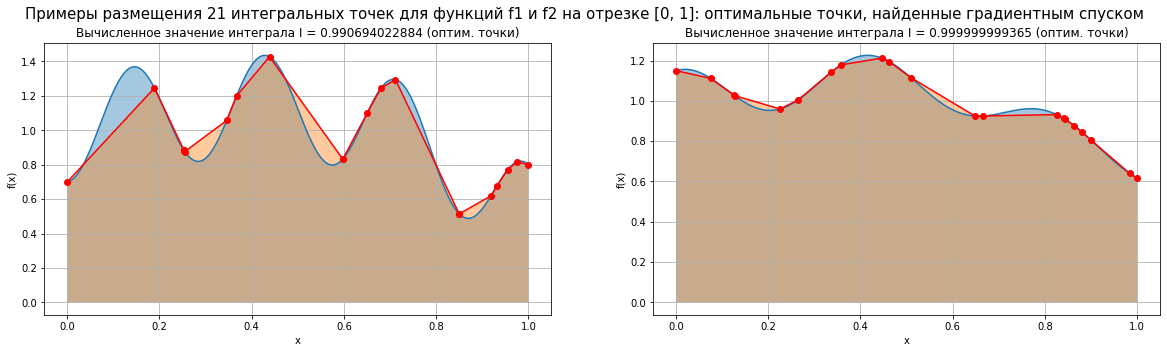

In [ ]:
plt.figure(figsize = (20,5))
plt.suptitle(f'Примеры размещения {n + 1} интегральных точек для функций f1 и f2 на отрезке [0, 1]: оптимальные точки, найденные градиентным спуском', fontsize=15);


funcs = [f1, f2]
x = torch.linspace(0, 1, 10000)

for i in range(2):
  f = funcs[i % 2]
  opt_int = Opt_int(f, n)
  opt_int.train(1.)
  plt.subplot(1,2,i + 1)
  plt.plot(x.detach(),f(x).detach())
  plt.fill_between(x.detach(), f(x).detach(), alpha = 0.4)
  
  int_x = opt_int.x.detach()
  int_x = torch.cat((torch.tensor([0.]),opt_int.x.detach().clone(), torch.tensor([1.])))

  plt.plot(int_x,f(int_x), '-r.', markersize=12)
  plt.fill_between(int_x, f(int_x), alpha = 0.4)
  plt.grid()
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.title(f'Вычисленное значение интеграла I = {np.round(opt_int.forward().detach(), 12)} (оптим. точки)')

1. При таком поиске точек интегрирования можно получить результат превосходящий по точности, в смысле минимума модуля разности истинного значения интеграла и найденной интегральной суммы, рассмотренные ранее алгоритмы.

1. Однако по графикам видно, что форма кусочно-линейной интерполяции значений по точкам интегрирования плохо соответствует оригинальной функции $f(x)$ (в качестве метрики, определяющей схожесть формы, здесь можно рассмотреть сумму модулей разности значений функции и интерполированных значений в серединах отрезков, на которые разбивается область интегрирования).

1. Чтобы увеличить соответствие формы кусочно-линейной интерполяции оригинальной функции, можно предложить добавить упомянутую ранее метрику в качестве штрафа к функции потерь, используемой при обучении (также предлагается домножить значение этой метрики на некоторый коэффициент $\lambda$).

In [ ]:
opt_int = Opt_int(f, n)

opt_int.train(1., lamb=0.45, verbose=True) # значение lamb = 0.45 - подобрано эмпирически

print(f'Prediction after training: I = {opt_int.forward()}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: loss = tensor([0.0468], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.001531585132
Epoch 11: loss = tensor([0.0448], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.001305506852
Epoch 21: loss = tensor([0.0428], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.001079210903
Epoch 31: loss = tensor([0.0409], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000855464681
Epoch 41: loss = tensor([0.0391], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000634499101
Epoch 51: loss = tensor([0.0375], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000424822204
Epoch 61: loss = tensor([0.0363], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000326318588
Epoch 71: loss = tensor([0.0351], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000255504745
Epoch 81: loss = tensor([0.0340], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000151147410
Epoch 91: loss = tensor([0.0328], dtype=torch.float64, grad_fn=<AddBackward0>), I = 1.000076241370
Epoch 101: 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


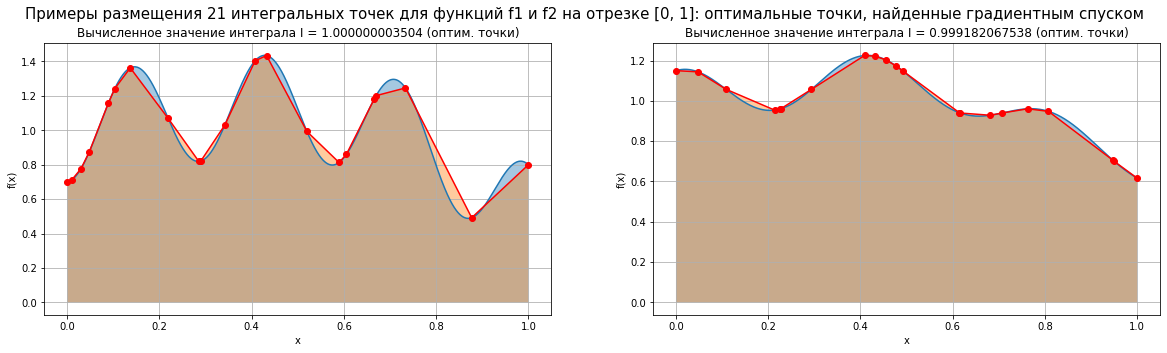

In [ ]:
plt.figure(figsize = (20,5))
plt.suptitle(f'Примеры размещения {n + 1} интегральных точек для функций f1 и f2 на отрезке [0, 1]: оптимальные точки, найденные градиентным спуском', fontsize=15);


funcs = [f1, f2]
x = torch.linspace(0, 1, 10000)

for i in range(2):
  f = funcs[i % 2]
  opt_int = Opt_int(f, n)
  opt_int.train(1.)
  plt.subplot(1,2,i + 1)
  plt.plot(x.detach(),f(x).detach())
  plt.fill_between(x.detach(), f(x).detach(), alpha = 0.4)
  
  int_x = opt_int.x.detach()
  int_x = torch.cat((torch.tensor([0.]),opt_int.x.detach().clone(), torch.tensor([1.])))
  #int_x, _ = int_x.sort()

  plt.plot(int_x,f(int_x), '-r.', markersize=12)
  plt.fill_between(int_x, f(int_x), alpha = 0.4)
  plt.grid()
  plt.xlabel('x')
  plt.ylabel('f(x)')
  plt.title(f'Вычисленное значение интеграла I = {np.round(opt_int.forward().detach(), 12)} (оптим. точки)')

1. По полученным графикам можно видеть, что добавление описанного выше штрафа позволило уменьшить площадь "зазоров" и областей, которые не лежат между графиком функции $f(x)$ и осью абсцисс.

1. Наличие такого штрафа может быть опциональным и применяться в зависимости от требований к конкретной задаче.

In [69]:
def test_torch_func(f, n_values, I_true):
  
  I_error = []
  for n in n_values:
    opt_int = Opt_int(f, n)
    opt_int.train(I_true,n_epochs=1500)
    I_error.append(torch.abs(I_true - opt_int.forward()))
  return I_error

In [70]:
# Тестирование алгоритма на функции f1
I_algs1.append( np.array([el.detach() for el in test_torch_func(f1, n_values, I_true)]))
for er, n in zip(I_algs1[-1], n_values):
  print(f"Значение абсолютной ошибки при n = {n} равно: {er}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Значение абсолютной ошибки при n = 5 равно: 0.002511646629767994
Значение абсолютной ошибки при n = 7 равно: 7.771561172376096e-16
Значение абсолютной ошибки при n = 10 равно: 2.220446049250313e-16
Значение абсолютной ошибки при n = 20 равно: 1.1102230246251565e-15
Значение абсолютной ошибки при n = 30 равно: 0.0
Значение абсолютной ошибки при n = 50 равно: 0.0
Значение абсолютной ошибки при n = 100 равно: 0.0
Значение абсолютной ошибки при n = 250 равно: 0.0
Значение абсолютной ошибки при n = 500 равно: 2.220446049250313e-16
Значение абсолютной ошибки при n = 1000 равно: 0.0


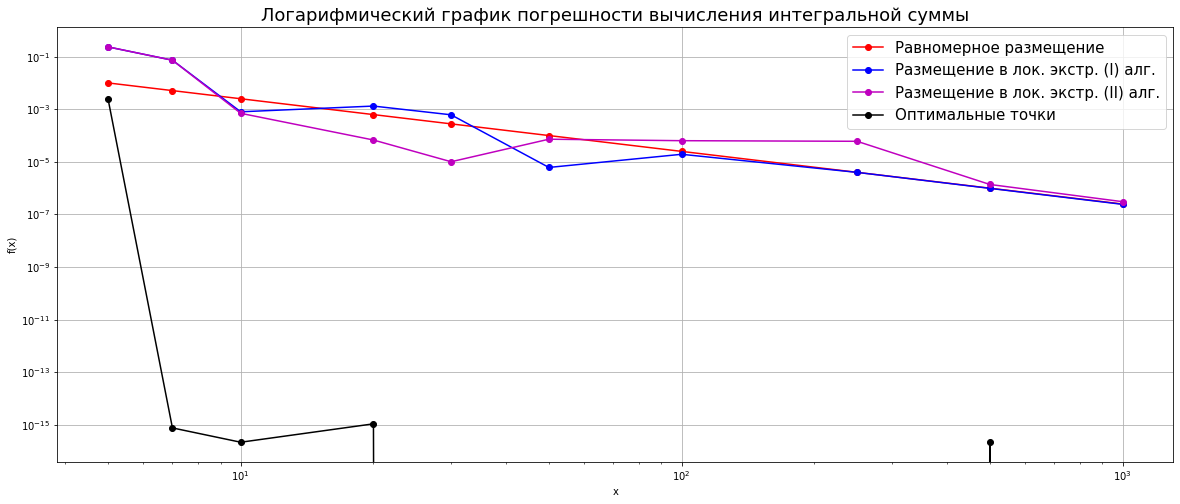

In [71]:
plt.figure(figsize = (20,8))

plt.loglog(n_values,I_algs1[0], '-r.', markersize=12)
plt.loglog(n_values,I_algs1[1], '-b.', markersize=12)
plt.loglog(n_values,I_algs1[2], '-m.', markersize=12)
plt.loglog(n_values,I_algs1[3], '-k.', markersize=12)
plt.legend(['Равномерное размещение', 'Размещение в лок. экстр. (I) алг.', 'Размещение в лок. экстр. (II) алг.', 'Оптимальные точки'], prop={'size': 15})
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Логарифмический график погрешности вычисления интегральной суммы', fontdict={'fontsize': 18});

In [76]:
# Тестирование алгоритма на функции f2
I_algs2.append( np.array([el.detach() for el in test_torch_func(f2, n_values, I_true)]))
for er, n in zip(I_algs2[-1], n_values):
  print(f"Значение абсолютной ошибки при n = {n} равно: {er}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Значение абсолютной ошибки при n = 5 равно: 0.0
Значение абсолютной ошибки при n = 7 равно: 4.252379992575328e-07
Значение абсолютной ошибки при n = 10 равно: 0.0
Значение абсолютной ошибки при n = 20 равно: 0.0
Значение абсолютной ошибки при n = 30 равно: 0.0
Значение абсолютной ошибки при n = 50 равно: 0.0
Значение абсолютной ошибки при n = 100 равно: 0.0
Значение абсолютной ошибки при n = 250 равно: 0.0
Значение абсолютной ошибки при n = 500 равно: 0.0
Значение абсолютной ошибки при n = 1000 равно: 3.405054016525355e-13


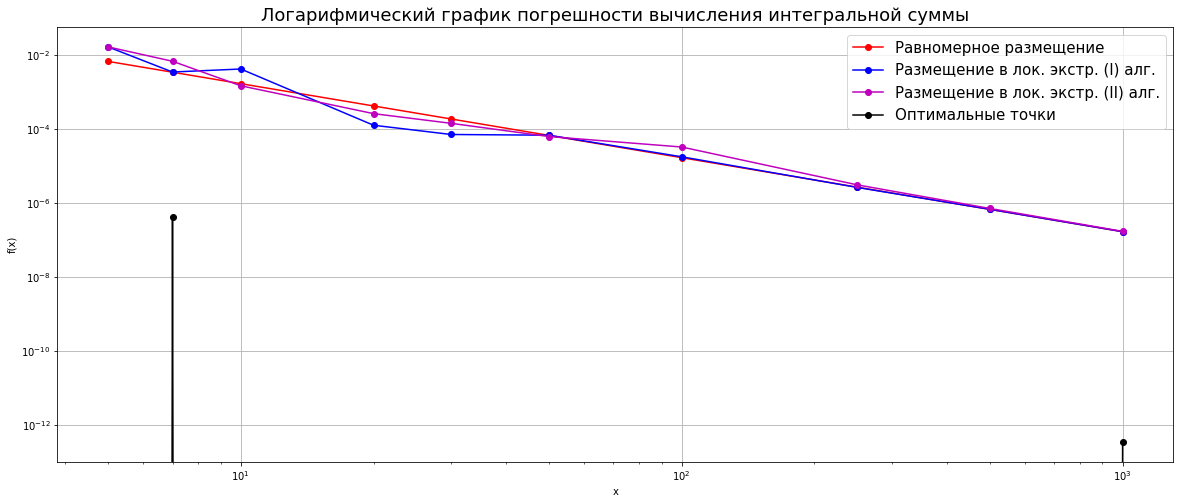

In [77]:
plt.figure(figsize = (20,8))

plt.loglog(n_values,I_algs2[0], '-r.', markersize=12)
plt.loglog(n_values,I_algs2[1], '-b.', markersize=12)
plt.loglog(n_values,I_algs2[2], '-m.', markersize=12)
plt.loglog(n_values,I_algs2[3], '-k.', markersize=12)
plt.legend(['Равномерное размещение', 'Размещение в лок. экстр. (I) алг.', 'Размещение в лок. экстр. (II) алг.', 'Оптимальные точки'], prop={'size': 15})
plt.grid()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Логарифмический график погрешности вычисления интегральной суммы', fontdict={'fontsize': 18});

По полученным графикам видно, что точность вычислений при использовании расположения интегральных точек, найденного с помощью градиентного спуска, на несколько порядков выше, по сравнению с точностью результатов рассмотренных ранее алгоритмов.